### Data Preprocessing and Feature Extraction for Ravdess affective speech data
Ravdess: contains 1440 audio recordings from 24 individuals.
 
Links: 

1- https://paperswithcode.com/dataset/ravdess 

2- https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio

###  Import necessary Libraries

In [1]:
import sys
import os
import pandas as pd
import numpy as np

''' Librosa:  is a python package for music and audio analysis.
 It provides the building blocks necessary to create music
 information retrieval systems: https://librosa.org/doc/latest/index.html
 conda install -c conda-forge librosa
 pip install librosa
 '''
import librosa
import librosa.display

import seaborn as sns               #!pip install seaborn
import matplotlib.pyplot as plt    #!pip install matplotlib

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# To play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical   #!pip install keras/conda install keras
from keras.callbacks import ModelCheckpoint




2024-06-17 10:52:10.252606: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-17 10:52:10.253864: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-17 10:52:10.265798: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-17 10:52:10.349072: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-17 10:52:12.512212: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

In [2]:
emoRav = "/home/nasr/GitHub/2024/sem_tut/audio/data/Ravdess/"

In [2]:
emoRav = "data/Ravdess/"


### Audio names interpretation
Each RAVDESS file has a unique filename. The filename consists of seven two-digit numerical identifiers, separated by hyphens
The identifiers are ordered: Modality–Channel–Emotion–Intensity–Statement–Repetition–Actor.wav. 


Modality (03 = Audio-only)
Channel (01 = Speech)
Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
Emotional intensity (01 = normal, 02 = strong). 
note: There is no strong intensity for the 'neutral' emotion.
Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
Repetition (01 = 1st repetition, 02 = 2nd repetition).
Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

e.g: file name (03-01-01-01-01-01-01.wav) -> 03 = Audio-only, 01= speech, 01= neutral, 01 = normal, 01 = "Kids are talking by the door", 01 = 1st repetition, 01 = male


### Build Dataframe

In [4]:
ravdess_directory_list = os.listdir(emoRav)
file_emotion = []
file_path = []

for dir in ravdess_directory_list:
    #print(emoRav+dir)
    actor = os.listdir(emoRav+dir)
    #print(actor)
    #print(dir)
    for file in os.listdir(emoRav+dir):
        files = os.listdir(emoRav+dir+"/"+file)
        
        for wav in files:
            part = wav.split('.')[0]
            part = part.split('-')
            
            file_emotion.append(int(part[2]))
            file_path.append(emoRav + dir + '/' +file+'/'+ wav)
            #print(file_path)
            
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])

emoRav_df = pd.concat([emotion_df, path_df], axis =1)        

In [7]:
# changing integers to actual emotions.
emoRav_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)

In [8]:
emoRav_df.head()

,Emotions,Path
0,angry,/home/nasr/GitHub/2024/sem_tut/audio/data/Ravd...
1,happy,/home/nasr/GitHub/2024/sem_tut/audio/data/Ravd...
2,happy,/home/nasr/GitHub/2024/sem_tut/audio/data/Ravd...
3,angry,/home/nasr/GitHub/2024/sem_tut/audio/data/Ravd...
4,happy,/home/nasr/GitHub/2024/sem_tut/audio/data/Ravd...


In [9]:
Audio(emoRav_df.iloc[4,1])

In [10]:
# Save the dataframe into CSV file
emoRav_df.to_csv("emoRav_data.csv", index=False)

#### Data Visualisation and Exploration

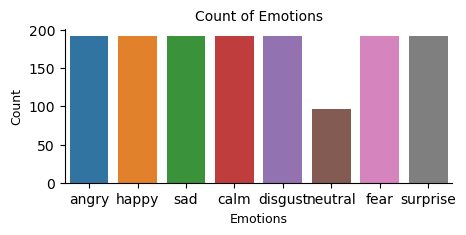

In [11]:
plt.figure(figsize=(5,2))
plt.title('Count of Emotions', size=10)
sns.countplot(x= emoRav_df.Emotions)
plt.ylabel('Count', size=9)
plt.xlabel('Emotions', size=9)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

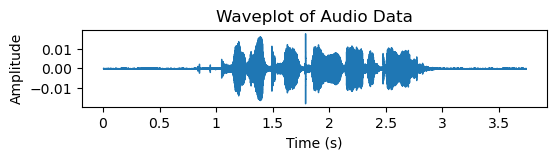

22050


In [12]:
y, sr = librosa.load(emoRav_df.iloc[15,1])
# Create wave plot
plt.figure(figsize=(6, 1))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveplot of Audio Data')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()
print(sr)

#### plot spectrograms

Spectograms - A spectrogram is a visual representation of the spectrum of frequencies of sound or other signals as they vary with time. It’s a representation of frequencies 
changing with respect to time for given audio/music signals.

Emotion is:  happy


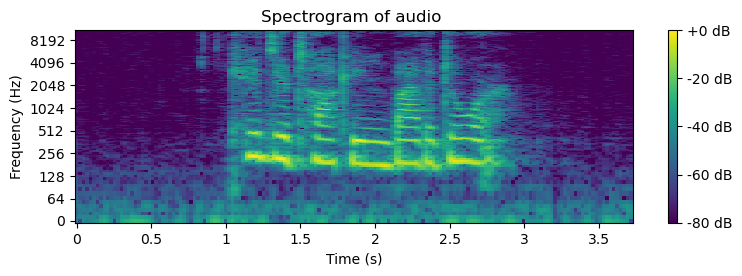

In [13]:
print("Emotion is: ", emoRav_df.iloc[4,0])

#compute the Short-Time Fourier Transform STFT
D = np.abs(librosa.stft(y))

#Compute the amplitude to decibels (db)
D_db = librosa.amplitude_to_db(D, ref= np.max)

#Plot the Spectrogram
plt.figure(figsize=(9,2.5))
librosa.display.specshow(D_db, sr=sr, x_axis='time', y_axis='log', cmap = 'viridis')
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram of audio ")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.show()

## Feature Extraction
Mel-Spectrogram: is a representation of the short-term power spectrum of a sound, based on a linear cosine transform of a log power spectrum on a nonlinear mel scale of frequency 
. It is commonly used as a feature for training neural network models in audio classification tasks.

A Mel Spectrogram makes two important changes relative to a regular Spectrogram that plots Frequency vs Time.

1- It uses the Mel Scale instead of Frequency on the y-axis.
2- It uses the Decibel Scale instead of Amplitude to indicate colors.

For deep learning models, we usually use this rather than a simple Spectrogram.
https://towardsdatascience.com/audio-deep-learning-made-simple-part-2-why-mel-spectrograms-perform-better-aad889a93505


Mel spectrogram breaks down the audio signal into a series of frequency bins, each corresponding to a particular Mel frequency band.

In [14]:
# Data Augmentation
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

In [15]:
def feature_extraction(data, sample_rate):
    results=np.array([]) 
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    # Convert Mel spectrogram to numerical features
    numerical_features = librosa.power_to_db(mel)
    results = np.hstack((results,mel))
    return results

def get_features(path):
    data, sample_rate = librosa.load(path, duration= 2.5, offset= 0.6)

    res = feature_extraction(data, sample_rate)
    result = np.array(res)
    # data with noise
    noise_data = noise(data)
    res2 = feature_extraction(noise_data, sample_rate)
    result = np.vstack((result, res2))
    return result


In [16]:
x, y =[], []
for path, emotion in zip(emoRav_df.Path, emoRav_df.Emotions):
    feature = get_features(path) 

    for ele in feature:
        x.append(ele)
        y.append(emotion)

In [17]:
len(x), len(y), emoRav_df.Path.shape

(2880, 2880, (1440,))

In [19]:
Features = pd.DataFrame(x)
Features['labels'] = y
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,labels
0,3.567070,0.044534,0.001252,0.000239,0.000243,0.003268,0.017687,0.257522,0.651980,1.289745,...,0.000679,0.000720,0.001191,0.001433,0.002023,0.008617,0.006640,0.003226,0.000118,angry
1,3.573328,0.046764,0.003103,0.001712,0.002607,0.005051,0.019660,0.262473,0.658310,1.295179,...,0.002572,0.002559,0.003121,0.003181,0.003836,0.010527,0.008518,0.005046,0.001995,angry
2,0.000199,0.000038,0.000088,0.000075,0.000232,0.016628,0.064284,0.170988,0.144401,0.076752,...,0.000013,0.000020,0.000019,0.000022,0.000020,0.000034,0.000060,0.000041,0.000002,happy
3,0.000539,0.000381,0.000377,0.000397,0.000621,0.017546,0.065297,0.170199,0.142157,0.076901,...,0.000385,0.000365,0.000381,0.000371,0.000376,0.000382,0.000437,0.000406,0.000374,happy
4,0.000553,0.000054,0.000014,0.000011,0.000087,0.006632,0.021300,0.132629,0.247925,1.605858,...,0.000355,0.000327,0.000407,0.000597,0.001652,0.001219,0.001134,0.000591,0.000061,happy


In [20]:
# Generate meaningful features names
feature_names = [f"time_step{i}" for i in range(128)]
last_column_name = Features.columns[-1]
Features.columns = feature_names+ [last_column_name]
Features.head()

,time_step0,time_step1,time_step2,time_step3,time_step4,time_step5,time_step6,time_step7,time_step8,time_step9,...,time_step119,time_step120,time_step121,time_step122,time_step123,time_step124,time_step125,time_step126,time_step127,labels
0,3.567070,0.044534,0.001252,0.000239,0.000243,0.003268,0.017687,0.257522,0.651980,1.289745,...,0.000679,0.000720,0.001191,0.001433,0.002023,0.008617,0.006640,0.003226,0.000118,angry
1,3.573328,0.046764,0.003103,0.001712,0.002607,0.005051,0.019660,0.262473,0.658310,1.295179,...,0.002572,0.002559,0.003121,0.003181,0.003836,0.010527,0.008518,0.005046,0.001995,angry
2,0.000199,0.000038,0.000088,0.000075,0.000232,0.016628,0.064284,0.170988,0.144401,0.076752,...,0.000013,0.000020,0.000019,0.000022,0.000020,0.000034,0.000060,0.000041,0.000002,happy
3,0.000539,0.000381,0.000377,0.000397,0.000621,0.017546,0.065297,0.170199,0.142157,0.076901,...,0.000385,0.000365,0.000381,0.000371,0.000376,0.000382,0.000437,0.000406,0.000374,happy
4,0.000553,0.000054,0.000014,0.000011,0.000087,0.006632,0.021300,0.132629,0.247925,1.605858,...,0.000355,0.000327,0.000407,0.000597,0.001652,0.001219,0.001134,0.000591,0.000061,happy


In [21]:
# Save the dataframe into csv file 
Features.to_csv('speech_features.csv', index=False)